## Según el grupo socioeconómico, ¿cuál fue el porcentaje de ingresos en las distintas universidades?
Para esta pregunta, graficamos para cada universidad y el porcentaje de sus estudiantes matriculados que pertenecen a cada tramo socioeconómico agrupado (GSE AB / C / D / E). La clasificación GSE se construye a partir del tramo de ingreso familiar (categorías numéricas 1–12) presente en el Archivo B, mapeado a grupos agregados para facilitar la comparación.
Se hizo un promedio de todos los años (2004–2025) combinando archivos de Matrícula y Archivo B, se saca el nombre de universidad desde la Oferta Académica anual. El resultado es una tabla porcentual y un gráfico apilado que permiten detectar la concentración de estratos altos (AB) o vulnerables (E) entre instituciones.


### Librerías
- `os`: recorrer directorios por año y localizar archivos cuyos nombres varían.
- `pandas`: carga, limpieza, merges y pivotes.
- `numpy`: manejo de valores faltantes y operaciones numéricas simples.
- `matplotlib.pyplot`: gráfico de barras horizontales apiladas (composición porcentual por GSE).
Se privilegia detección automática de archivos y columnas para robustez ante cambios.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Carpeta y rango de años
Se define la carpeta base `raw_data` donde se asume reside la estructura `/AÑO/*.csv`. El rango 2004–2025 permite capturar evolución reciente, incluyendo expansión de cobertura y cambios en oferta universitaria.


In [6]:
BASE = "raw_data"
YEARS = range(2004, 2026)


### Código
Funciones clave:

- `clean_df`: homogeniza encabezados y valores removiendo comillas y espacios, reduciendo fallos de coincidencia en merges.
- `find_csv` / `find_matr_csv` / `find_b_csv`: búsqueda de archivos cuyos nombres cambian entre años (prefijos variados).
- `find_ingreso_col`: para detectar la columna de ingreso familiar sin depender de un nombre único.
- `tramo_to_gse`: mapea tramo numérico (1–12) a categorías socioeconómicas agregadas (AB, C, D, E) simplificando la comparación entre universidades.

Flujo general:
1. Iterar años y localizar archivos requeridos.
2. Cargar CSVs (separador `;`, encoding `latin1`) y limpiar.
3. Validar columnas esenciales (`CODIGO`, `ID_aux`).
4. Detectar columna ingreso y extraer tramo numérico robustamente (regex).
5. Mapear tramo → GSE y agregar año.
6. Concatenar todos los dataframes válidos.
7. Normalizar código DEMRE para derivar universidad (`CODIGO_UNIV`).
8. Extraer nombre institucional desde Oferta Académica consolidando la variante más frecuente por código (no se usa diccionario fijo manual).
9. Construir tabla porcentual pivote por universidad y GSE.

In [7]:
def clean_df(df):
    """Limpia comillas y espacios en headers y valores."""
    df.columns = df.columns.str.strip().str.replace('"', '')
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.replace('"', '')
    return df

def find_csv(year, keyword):
    """
    Busca un CSV dentro de raw_data/{year} cuyo nombre contenga keyword.
    """
    root = os.path.join(BASE, str(year))
    if not os.path.isdir(root):
        return None
    for dirpath, _, files in os.walk(root):
        for f in files:
            name = f.lower()
            if name.endswith(".csv") and keyword in name:
                return os.path.join(dirpath, f)
    return None

def find_matr_csv(year):
    """Busca el archivo de matrícula para un año dado con varias claves."""
    for key in ["archivomat", "matr", "mat_"]:
        p = find_csv(year, key)
        if p is not None:
            return p
    return None

def find_b_csv(year):
    """Busca el archivo B (inscritos) para un año dado."""
    for key in ["archivob", "archivo b", "archivob_"]:
        p = find_csv(year, key)
        if p is not None:
            return p
    return None

def find_ingreso_col(dfb):
    """
    Detecta la columna de ingreso familiar 
    usando el nombre de columna.
    """
    cols = list(dfb.columns)
    upper_cols = {c.upper(): c for c in cols}

    # Prioridades exactas
    priority_exact = [
        "INGRESO_BRUTO_FAM",
        "INGRESO_BRUTO_FA",
        "INGRESO_PERCAPITA_GRUPO_FA",
        "INGRESO_PERCAPITA_FA",
        "INGRESO_FAM",
        "TRAMO_INGRESO_FA",
        "TRAMO_INGRESO_FAM",
    ]
    for p in priority_exact:
        if p in upper_cols:
            return upper_cols[p]

    candidates = []
    for c in cols:
        cl = c.lower().strip()
        cln = cl.replace("_", "").replace(" ", "")
        if ("ingreso" in cl or "ing" in cln):
            if ("fam" in cln) or ("fa" in cln) or ("grupo" in cln) or ("percapita" in cln):
                candidates.append(c)

    if candidates:
        candidates.sort(key=lambda x: -len(x))  # la más descriptiva primero
        return candidates[0]

    return None

def tramo_to_gse(t):
    """Mapea tramo de ingreso (1–12) a GSE AB/C/D/E."""
    if pd.isna(t):
        return np.nan
    try:
        t = int(t)
    except:
        return np.nan
    if t in (1, 2):
        return "E"      # muy bajos
    if t in (3, 4):
        return "D"      # bajos
    if 5 <= t <= 8:
        return "C"      # medios
    if 9 <= t <= 12:
        return "AB"     # altos
    return np.nan

def find_oferta(year):
    """Busca el Excel de Oferta Académica para un año dado."""
    root = os.path.join(BASE, str(year))
    if not os.path.isdir(root):
        return None
    for dirpath, _, files in os.walk(root):
        for f in files:
            name = f.lower()
            if name.endswith(".xlsx") and "ofertaacad" in name:
                return os.path.join(dirpath, f)
    return None

# Función para corregir
_def_mojibake_map = {
    "UNIVERSIDAD DE LAS AMÃ‰RICAS": "UNIVERSIDAD DE LAS AMÉRICAS",
    "UNIVERSIDAD DE LAS AMÃRICAS": "UNIVERSIDAD DE LAS AMÉRICAS",  # variante posible
    "LAS AMÃ‰RICAS": "LAS AMÉRICAS",
}

def arreglar_nombre(s):
    if not isinstance(s, str):
        return s
    return _def_mojibake_map.get(s, s)

# 1) CARGA MULTI-AÑO: MATRÍCULA + ARCHIVO B (INGRESOS)

dfs = []

for y in YEARS:
    try:
        mat = find_matr_csv(y)
        bfile = find_b_csv(y)

        if mat is None or bfile is None:
            print(f"{y}: faltan archivos necesarios (Matrícula o Archivo B)")
            continue

        dfm = pd.read_csv(mat, sep=";", encoding="latin1", low_memory=False)
        dfb = pd.read_csv(bfile, sep=";", encoding="latin1", low_memory=False)

        dfm = clean_df(dfm)
        dfb = clean_df(dfb)

        if "CODIGO" not in dfm.columns:
            print(f"{y}: Matrícula sin columna CODIGO")
            continue
        if "ID_aux" not in dfm.columns or "ID_aux" not in dfb.columns:
            print(f"{y}: falta ID_aux en Matrícula o Archivo B")
            continue

        # Columna de ingreso familiar (tramos)
        ingreso_col = find_ingreso_col(dfb)
        if ingreso_col is None:
            print(f"{y}: no se encontró columna de ingreso familiar en Archivo B")
            continue

        # Merge: Matrícula + columna de ingreso familiar desde B
        df = dfm.merge(
            dfb[["ID_aux", ingreso_col]],
            on="ID_aux",
            how="left"
        )

        # Normalizar el tramo (extraer número 1–12)
        raw = df[ingreso_col].astype(str).str.strip()
        raw = raw.replace({"": np.nan, "NA": np.nan, "NaN": np.nan, "nan": np.nan})
        tramo = raw.str.extract(r"(\d+)", expand=False)
        df["ING_TRAMO"] = pd.to_numeric(tramo, errors="coerce")

        # Mapear a GSE ingreso
        df["GSE_ING"] = df["ING_TRAMO"].apply(tramo_to_gse)
        df["AÑO"] = y

        dfs.append(df)
        print(f"{y}: OK (Matrícula = {os.path.basename(mat)}, ingreso = {ingreso_col})")

    except Exception as e:
        print(f"{y}: {e}")

if not dfs:
    raise RuntimeError("No se pudo construir ningún data frame multi-año con ingreso familiar.")

df_all = pd.concat(dfs, ignore_index=True)

# 2) NORMALIZAR CODIGO_UNIV DESDE CODIGO (DEMRE)
df_all["CODIGO_UNIV"] = (
    df_all["CODIGO"]
    .astype(str)
    .str.replace(r"[^0-9]", "", regex=True)
    .str.slice(0, 2)          # primeros 2 dígitos = universidad
    .replace("", np.nan)
)

df_all = df_all.dropna(subset=["CODIGO_UNIV"])
df_all["CODIGO_UNIV"] = df_all["CODIGO_UNIV"].astype(int)


# 3) CONSTRUIR MAPA CODIGO_UNIV → NOMBRE_UNIV CON OFERTA
map_piezas = []

for y in YEARS:
    ruta = find_oferta(y)
    if ruta is None:
        print(f"{y}: sin Oferta Académica")
        continue

    of = pd.read_excel(ruta)
    cols_u = {c.upper(): c for c in of.columns}

    # nombre de universidad
    nombre_col = None
    if "UNIVERSIDAD" in cols_u:
        nombre_col = cols_u["UNIVERSIDAD"]
    elif "NOMBRE_UNIVERSIDAD" in cols_u:
        nombre_col = cols_u["NOMBRE_UNIVERSIDAD"]
    else:
        print(f"{y}: Oferta sin columna de nombre de universidad")
        continue

    # código de universidad
    coduni_col = None
    if "CODIGO_UNIV" in cols_u:
        coduni_col = cols_u["CODIGO_UNIV"]
    elif "CODIGO_UNIVERSIDAD" in cols_u:
        coduni_col = cols_u["CODIGO_UNIVERSIDAD"]
    elif "UNI_CODIGO" in cols_u:
        coduni_col = cols_u["UNI_CODIGO"]

    df_tmp = pd.DataFrame()
    df_tmp["NOMBRE_UNIV"] = of[nombre_col].astype(str).str.strip().apply(arreglar_nombre)

    if coduni_col is not None:
        df_tmp["CODIGO_UNIV"] = (
            of[coduni_col]
            .astype(str)
            .str.replace(r"[^0-9]", "", regex=True)
            .str.slice(0, 2)
        )
    else:
        # derivar desde código de carrera
        car_col = None
        if "CODIGO_CARRERA" in cols_u:
            car_col = cols_u["CODIGO_CARRERA"]
        elif "CODIGO" in cols_u:
            car_col = cols_u["CODIGO"]
        else:
            print(f"{y}: Oferta sin código de universidad ni de carrera usable")
            continue

        df_tmp["CODIGO_UNIV"] = (
            of[car_col]
            .astype(str)
            .str.replace(r"[^0-9]", "", regex=True)
            .str.slice(0, 2)
        )

    df_tmp = df_tmp.dropna(subset=["CODIGO_UNIV"])
    df_tmp["CODIGO_UNIV"] = df_tmp["CODIGO_UNIV"].astype(int)
    df_tmp = df_tmp[["CODIGO_UNIV", "NOMBRE_UNIV"]].drop_duplicates()

    map_piezas.append(df_tmp)


univ_df = pd.concat(map_piezas, ignore_index=True)
univ_df["NOMBRE_UNIV"] = univ_df["NOMBRE_UNIV"].str.strip().apply(arreglar_nombre)

univ_map = (
    univ_df
    .groupby(["CODIGO_UNIV", "NOMBRE_UNIV"])
    .size()
    .reset_index(name="n")
    .sort_values(["CODIGO_UNIV", "n"], ascending=[True, False])
    .groupby("CODIGO_UNIV")["NOMBRE_UNIV"]
    .first()
    .to_dict()
)

print("\n=== Mapa CODIGO_UNIV → NOMBRE_UNIV (resumen) ===")
for k in sorted(univ_map.keys()):
    print(k, "→", univ_map[k])


# 4) APLICAR MAPE0 Y CONSTRUIR TABLA GSE (INGRESO)
df_all["NOMBRE_UNIV"] = df_all["CODIGO_UNIV"].map(univ_map)
df_all["NOMBRE_UNIV"] = df_all["NOMBRE_UNIV"].fillna("Universidad no identificada")

df_valid = df_all.dropna(subset=["GSE_ING", "NOMBRE_UNIV"])

tabla_counts = pd.pivot_table(
    df_valid,
    index="NOMBRE_UNIV",
    columns="GSE_ING",
    values="ID_aux",
    aggfunc="count",
    fill_value=0
)

tabla_pct = tabla_counts.div(tabla_counts.sum(axis=1), axis=0) * 100
cols_gse = [c for c in ["AB", "C", "D", "E"] if c in tabla_pct.columns]
tabla_pct = tabla_pct[cols_gse]

display(tabla_pct.head())
print("Columnas GSE (ingresos):", cols_gse)






2004: OK (Matrícula = ArchivoMat_Adm2004.csv, ingreso = INGRESO_BRUTO_FAM)
2005: OK (Matrícula = ArchivoMat_Adm2005.csv, ingreso = INGRESO_BRUTO_FAM)
2005: OK (Matrícula = ArchivoMat_Adm2005.csv, ingreso = INGRESO_BRUTO_FAM)
2006: OK (Matrícula = ArchivoMat_Adm2006.csv, ingreso = INGRESO_BRUTO_FAM)
2006: OK (Matrícula = ArchivoMat_Adm2006.csv, ingreso = INGRESO_BRUTO_FAM)
2007: OK (Matrícula = ArchivoMat_Adm2007.csv, ingreso = INGRESO_BRUTO_FAM)
2007: OK (Matrícula = ArchivoMat_Adm2007.csv, ingreso = INGRESO_BRUTO_FAM)
2008: OK (Matrícula = ArchivoMat_Adm2008.csv, ingreso = INGRESO_BRUTO_FAM)
2008: OK (Matrícula = ArchivoMat_Adm2008.csv, ingreso = INGRESO_BRUTO_FAM)
2009: OK (Matrícula = ArchivoMat_Adm2009.csv, ingreso = INGRESO_BRUTO_FAM)
2009: OK (Matrícula = ArchivoMat_Adm2009.csv, ingreso = INGRESO_BRUTO_FAM)
2010: OK (Matrícula = ArchivoMat_Adm2010.csv, ingreso = INGRESO_BRUTO_FAM)
2010: OK (Matrícula = ArchivoMat_Adm2010.csv, ingreso = INGRESO_BRUTO_FAM)
2011: OK (Matrícula = Arc

GSE_ING,AB,C,D,E
NOMBRE_UNIV,,,,
PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE,45.224026,23.641046,14.650097,16.484832
PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO,13.047671,23.714130,24.319154,38.919045
UNIVERSIDAD ACADEMIA DE HUMANISMO CRISTIANO,6.589447,28.211068,28.262548,36.936937
UNIVERSIDAD ADOLFO IBAÑEZ,71.976190,17.909524,5.966667,4.147619
UNIVERSIDAD ADVENTISTA DE CHILE,11.296534,34.274711,22.079589,32.349166


Columnas GSE (ingresos): ['AB', 'C', 'D', 'E']


#### Explicación

- Se combinaron los registros de Matrícula y del Archivo B usando el identificador común `ID_aux`. Del campo de ingreso familiar se extrae el primer número válido (1–12); si no hay número o está mal informado, se marca como desconocido.
- Esos tramos numéricos se agrupan en cuatro GSE: 1–2 → E (más vulnerables), 3–4 → D, 5–8 → C y 9–12 → AB (más altos).
- Para cada universidad se cuentan estudiantes por GSE y luego se convierten a porcentajes por fila, de modo que la suma por universidad es 100%. Esto permite comparar composiciones relativas entre instituciones.
- El gráfico muestra barras horizontales apiladas con los porcentajes de cada GSE, facilitando ver si una universidad concentra estudiantes en tramos altos (AB) o en tramos vulnerables (E).
- El orden de las barras está basado en el porcentaje AB (de mayor a menor), lo que hace más evidente qué instituciones tienen mayor representación en los tramos altos.


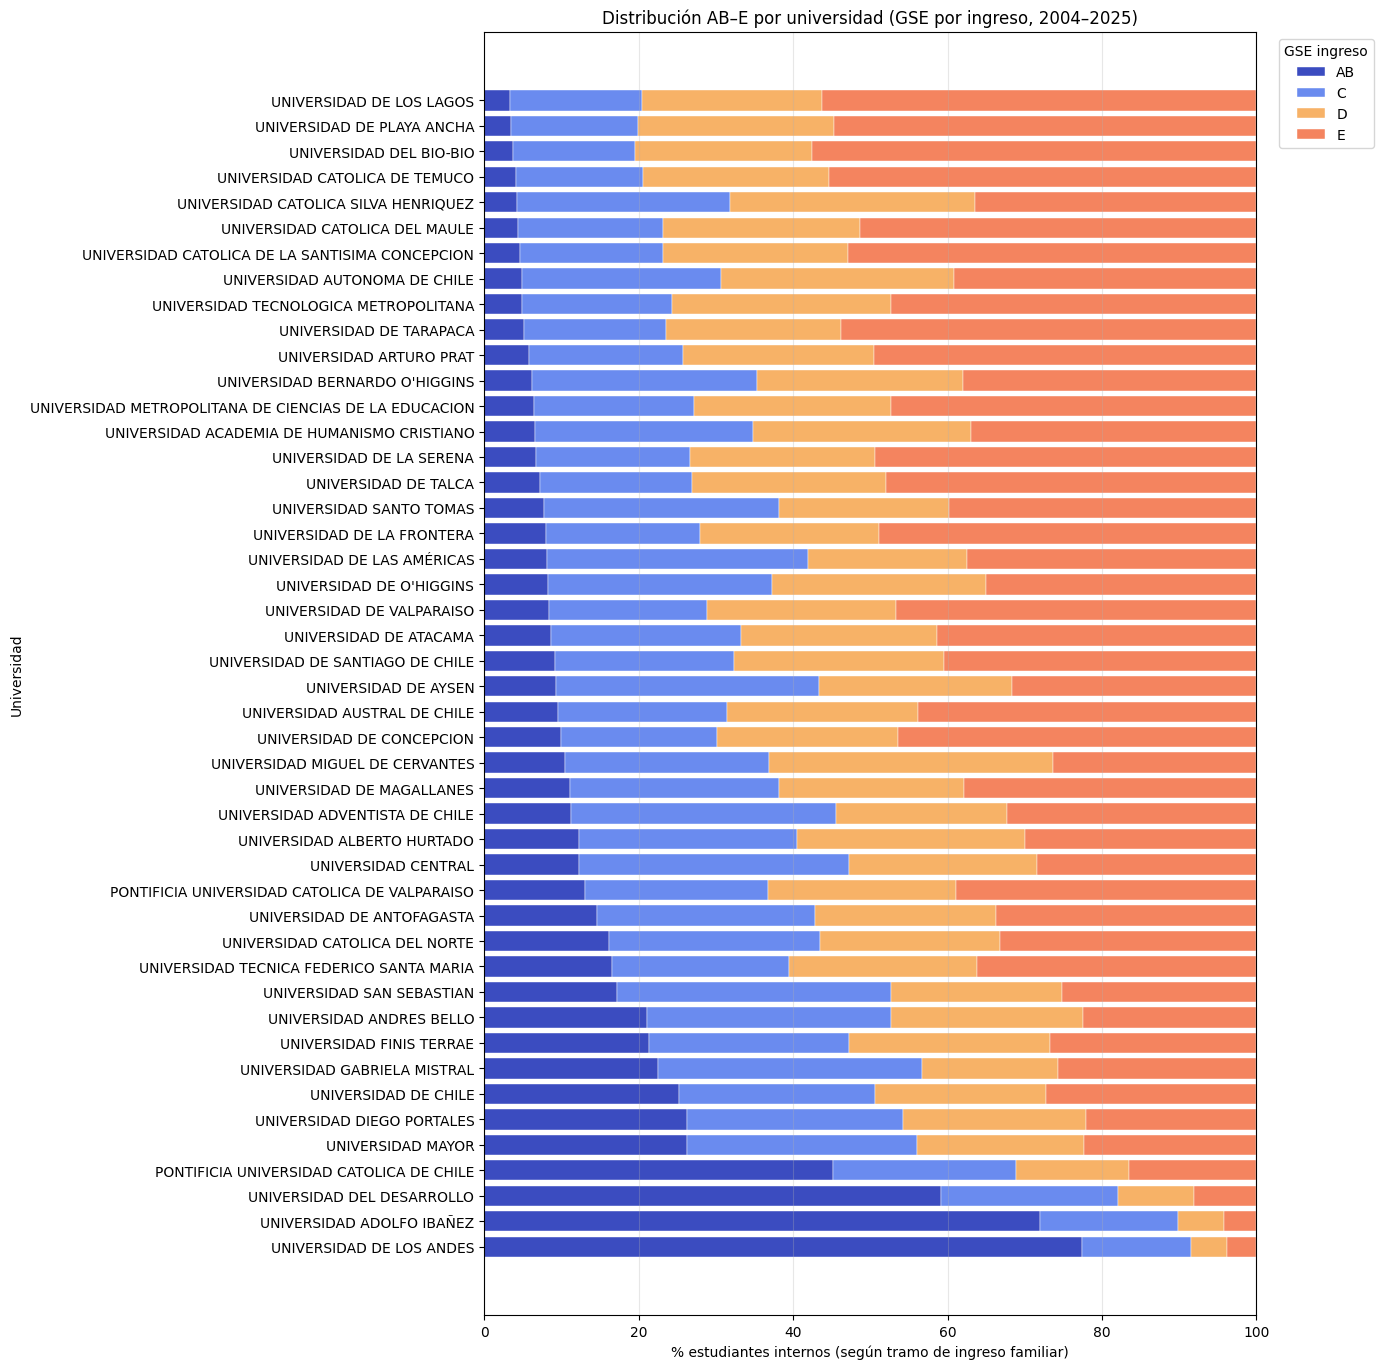

In [8]:
tabla_plot = tabla_pct.copy()
if "AB" in tabla_plot.columns:
    tabla_plot = tabla_plot.sort_values("AB", ascending=False)

colors = {
    "AB": "#3b4cc0",
    "C":  "#6a8bef",
    "D":  "#f7b267",
    "E":  "#f4845f",
}

fig_h = max(6, min(0.3 * len(tabla_plot), 30))
fig, ax = plt.subplots(figsize=(14, fig_h))

left = np.zeros(len(tabla_plot))
y_labels = tabla_plot.index.astype(str)

for c in cols_gse:
    ax.barh(
        y_labels,
        tabla_plot[c].values,
        left=left,
        label=c,
        color=colors.get(c, "#999999"),
        edgecolor="white",
        linewidth=0.3
    )
    left += tabla_plot[c].values

ax.set_xlabel("% estudiantes internos (según tramo de ingreso familiar)")
ax.set_ylabel("Universidad")
ax.set_title("Distribución AB–E por universidad (GSE por ingreso, 2004–2025)")
ax.set_xlim(0, 100)
ax.legend(title="GSE ingreso", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()

ruta = os.path.join("graficos-imagenes")
plt.savefig(os.path.join(ruta, 'pregunta3.png')) # guardamos el grafico en su carpeta correspondiente
plt.show()
